In [198]:
%reset -f

In [199]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import math as math
from scipy.integrate import solve_ivp

## Energy Balance Reboiler

df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')


In [200]:
# Getting data from file and making fitted line
Temp_list_Me = df_Me['Temperature'].values.tolist()
Cp_list_Me = df_Me['Cp'].values.tolist()
a_Me, b_Me, c_Me = np.polyfit(Temp_list_Me, Cp_list_Me, deg=2)

'''plt.plot(Temp_list_Me, Cp_list_Me, "o")
plt.plot(Temp_list_Me, np.polyval((a_Me, b_Me, c_Me),Temp_list_Me), "-")
plt.xlabel('T[K]')
plt.ylabel('Cp') 
plt.title('Methanol heat capacity')
plt.show()'''

# Heat Capacity Isopropanol

# Getting data and making fitted line
Temp_list_Iso = df_Iso['Temp'].values.tolist()
Cp_list_Iso = df_Iso['Cp'].values.tolist()
a_Iso, b_Iso, c_Iso = np.polyfit(Temp_list_Iso, Cp_list_Iso, deg=2)
Temps_Iso_model = np.linspace(-20, 85, 22)
Temps_Iso_model_K  = [x+273.15 for x in Temps_Iso_model] # convert to Kelvin

'''plt.plot(Temp_list_Iso, Cp_list_Iso, "o")
plt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")
plt.xlabel('T[K]') # label on the x axis
plt.ylabel('Cp') # label on the y axis
plt.title('Isopropanol heat capacity')
plt.show()'''

'plt.plot(Temp_list_Iso, Cp_list_Iso, "o")\nplt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")\nplt.xlabel(\'T[K]\') # label on the x axis\nplt.ylabel(\'Cp\') # label on the y axis\nplt.title(\'Isopropanol heat capacity\')\nplt.show()'

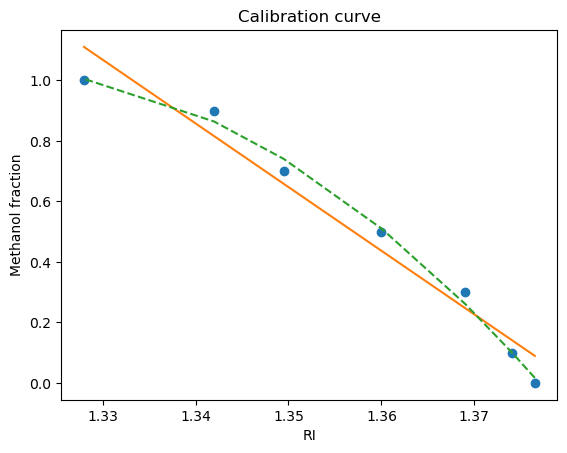

0.5105995532411498


In [201]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [202]:
#Constants 

R = 8.3144598    # Gas constant J/molK
g = 9.807        # Gravitational acceleration m/s^2

# Reboiler info and trey
A_r = 1                  # Evaporation surface area m2
dH_vap_Me = 37340        # Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 44000
eff = 1 #640/751         # Heater efficiency (around 0.85)
T0 = 298                 #K
V  = 0.01                # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac     # Mole fraction isopropanol
dens_Me = 792 * 1000     #g/m3
dens_Iso = 786 * 1000    #g/m3
dens_mix_L = ((792+786)/2) * 1000 #g/m3
M_Me = 32.02             #g/mol
M_Iso = 60.1             #g/mol
Vm_Me = 40.75            # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm           # Total number of moles in mixture
n_Me = Me_frac*n_total   # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
power_percent = 0.7
power = eff*power_percent*2000      #J/s (maximum power is 2kW)
A_tray = ((2.5*0.01)**2) * math.pi  #surface area of one tray in m 
lw =  0.025                      #length weir in m 
How = 0.005                      #height over outlet weir in m  
dp = 547.7                       #pressure drop over entire column in Pa
x_iso_in = 0.5                   #Isopropanol fraction inlet
x_me_in = 0.5                    #Methanol fraction inlet
RR = 0.2                         #Reflux ratio

In [203]:
#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Total liquid avg heat transfer coeff in J/mol.K
def Cp_L(x_me, x_iso):
    Cp_L = x_me*Cp_L_me + x_iso*Cp_L_iso
    return Cp_L

#Total vapor avg heat transfer coeff in J/mol.K
def Cp_v(y_me, y_iso):
    Cp_v = y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_v

#Total (liquid+vapor) avg heat transfer coeff in J/mol.K
def Cp_tot(Nme_L,Niso_L,Nme_v,Niso_v):
    x_me = Nme_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    x_iso = Niso_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_me = Nme_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_iso = Niso_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    Cp_tot = x_me*Cp_L_me + x_iso*Cp_L_iso + y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_tot


# Vapor pressure for both compounds in Pa 
def p0_me(T):
    #Antonie constants-methanol 
    A_me = 8.08097
    B_me = 1582.27
    C_me = 239.7
    #vapour pressure
    anto_me = A_me - (B_me/(T+C_me))
    p0_me_mmHg = math.pow(10,anto_me) 
    p0_me = p0_me_mmHg/0.00750062   #Pa

    return p0_me   


def p0_iso(T):
    #Antoine constants isopropanol
    A_iso = 8.00308
    B_iso =	1505.52
    C_iso = 211.6
    #vapour pressure 
    anto_iso = A_iso - (B_iso/(T+C_iso))
    p0_iso_mmHg = math.pow(10,anto_iso)
    p0_iso = p0_iso_mmHg/0.00750062   #Pa
    
    return p0_iso


In [204]:
k_me = 1.34  #m/s 
k_iso = 1.27 #m/s


In [205]:
params = {
    'R': R,          # Gas constant
    'k_me': k_me,    # mass coefficient methanol,
    'k_iso': k_iso,  # mass coefficient isopropanol
    'A_r': A_r,      #evaporation surface area of reboiler 
    'A_tray': A_tray,#evaporation surface area of each tray 
    'dens_mix_L': dens_mix_L,  #density of mixture 
    'M_Me': M_Me,
    'M_Iso': M_Iso,
    'lw': lw,
    'How': How,
    'x_me_in': x_me_in,
    'x_iso_in': x_iso_in,
    'dH_vap_Me': dH_vap_Me,
    'dH_vap_iso': dH_vap_iso,  
    'power': power 
}

In [206]:
def modelODE(t,N, params):
    
    R = params['R']
    k_me = params['k_me']
    k_iso = params['k_iso']
    A_r = params['A_r']
    A_tray = params['A_tray']
    dens_mix_L = params['dens_mix_L']
    M_Me = params['M_Me']
    M_Iso = params['M_Iso']
    lw = params['lw']
    How = params['How']
    x_me_in = params['x_me_in']
    x_iso_in = params['x_iso_in']



    T_ref = 298.15
    Q_cool = 104 
    T_cool = 293.15
    T_tray = 337.8

    Nme_LR = N[0]
    Niso_LR = N[1]
    Nme_vR = N[2]
    Niso_vR = N[3]
    N_L_totR = Nme_LR+Niso_LR
    N_v_totR = Nme_vR+Niso_vR

    T = N[4]

    Nme_L_tray = N[5]
    Niso_L_tray = N[6]
    Nme_v_tray = N[7]
    Niso_v_tray = N[8]
    N_L_tot_tray = Nme_L_tray+Niso_L_tray
    N_v_tot_tray = Nme_v_tray+Niso_v_tray




    #mol fractions reboiler
    y_meR = Nme_vR/N_v_totR
    x_meR = Nme_LR/N_L_totR
    y_isoR = Niso_vR/N_v_totR
    x_isoR = Niso_LR/N_L_totR

    #mol fractions tray
    y_me_tray = Nme_v_tray/N_v_totR
    x_me_tray = Nme_L_tray /N_v_tot_tray
    y_iso_tray = Niso_v_tray /N_v_tot_tray
    x_iso_tray = Niso_L_tray /N_L_tot_tray

    
    dNdt = np.zeros(9)

    #p_tot = y_me*p0_me(T) + y_iso*p0_iso(T)
    p_tot = 101325

    #evaporation rate in reboiler 
    evap_me = 0.00001*A_r * ((x_meR*p0_me(T) - p_tot*y_meR)/(R*T))
    evap_iso = 0.00001*A_r * ((x_isoR*p0_iso(T) - p_tot*y_isoR)/(R*T))
    #evaporation rate in tray
    evap_tray_me = 0.00001*A_tray * ((x_me_tray*p0_me(T) - p_tot*y_me_tray)/(R*T_tray))
    evap_tray_iso = 0.00001*A_tray * ((x_iso_tray*p0_iso(T) - p_tot*y_iso_tray)/(R*T_tray))

    if Nme_LR <= 0:
        evap_me = 0
    if Niso_LR <= 0:
        evap_iso = 0
    

    L_inflow = 2 * 0.001/3600 * dens_mix_L/(x_me_in*M_Me + x_iso_in*M_Iso)
    L_weir = (dens_mix_L/(M_Me*x_me_tray+M_Iso*x_iso_tray))*1.8385*lw*(How**1.5) #mol/s
    V_tray = 1   
    L_condenser = (1/(Cp_L(y_me_tray,y_iso_tray)*(T_cool-T_ref))) * (V_tray*((Cp_v(y_me_tray,y_iso_tray)*(T-T_ref)) + dH_vap_Me + dH_vap_iso) - Q_cool)
    V_reboiler = (V_tray*((Cp_v(y_me_tray,y_iso_tray)*(T-T_ref)) + dH_vap_Me + dH_vap_iso) + L_weir*Cp_L(x_me_tray,x_iso_tray)*(T_tray-T_ref) - L_inflow*Cp_L(x_me_in,x_iso_in)*(T-T_ref) - L_condenser*(1-RR)*Cp_L(y_me_tray,y_iso_tray)*(T_cool-T_ref))

    
    dNdt[0] = -evap_me + L_weir*x_me_tray      #meL Reboiler
    dNdt[1] = -evap_iso + L_weir*x_iso_tray    #isoL Reboiler
    dNdt[2] = evap_me - V_reboiler*y_meR       #meV Reboiler
    dNdt[3] = evap_iso - V_reboiler*y_isoR     #isoV Reboiler
    #energy balance reboiler 
    dNdt[4] = (1/(Cp_tot(Nme_LR,Niso_LR,Nme_vR,Niso_vR)*(N_L_totR+N_v_totR))) * (power + (L_weir*Cp_L(x_me_tray,x_iso_tray)*(T_tray-T_ref)) - (V_reboiler*(Cp_v(y_meR,y_isoR)*(T-T_ref) + dH_vap_Me + dH_vap_iso)))

    dNdt[5] = -evap_tray_me + L_inflow*x_me_in + L_condenser*(1-RR)*y_me_tray - L_weir*x_me_tray      #meL Tray
    dNdt[6] = -evap_tray_iso + L_inflow*x_iso_in + L_condenser*(1-RR)*y_iso_tray - L_weir*x_me_tray   #isoL Tray
    dNdt[7] = evap_tray_me + V_reboiler*y_meR - V_tray*y_me_tray       #meV Tray
    dNdt[8] = evap_tray_iso + V_reboiler*y_isoR - V_tray*y_iso_tray    #isoV Tray
    
    return dNdt

In [207]:
N_initial = [115, 115, 0.001, 0.001, 293, 0.001, 0.001, 0.001, 0.001] # meL isoL meV isoV
#tspan = np.linspace(0, 10000, 10000)
t0, tf = 0, 10000
sol = solve_ivp(modelODE, (t0, tf), N_initial,args = (params,))
#N = odeint(modelODE, N_initial, tspan, args = (params,))


OverflowError: math range error

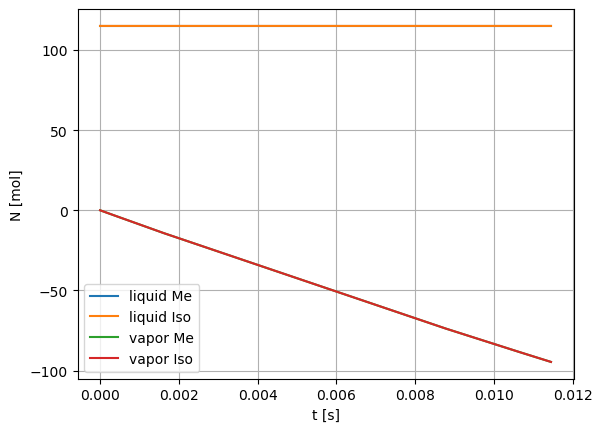

In [ ]:
#plt.plot(tspan, N[:,0], label = 'liquid Me')
#plt.plot(tspan, N[:,1], label = 'liquid Iso')
#plt.plot(tspan, N[:,2], label = 'vapor Me')
#plt.plot(tspan, N[:,3], label = 'vapor Iso')

plt.plot(sol.t, sol.y[0], label = 'liquid Me')
plt.plot(sol.t, sol.y[1], label = 'liquid Iso')
plt.plot(sol.t, sol.y[2], label = 'vapor Me')
plt.plot(sol.t, sol.y[3], label = 'vapor Iso')

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

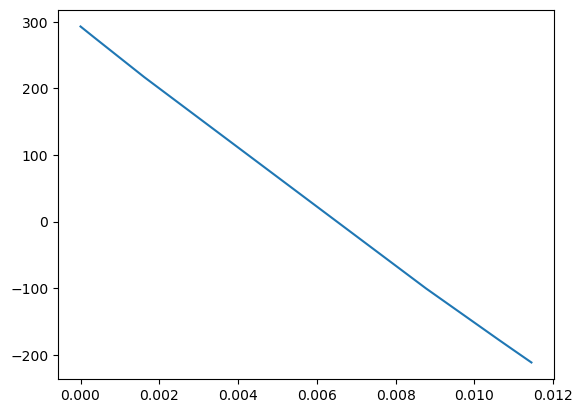

In [ ]:
#plt.plot(tspan,N[:,4])
plt.plot(sol.t,sol.y[4])